# Project #2. Extented Kalman Filter. Localization

The project is denoted to nonlinear Kalman Filter version - so called [Extended Kalman Filter (EKF)](https://en.wikipedia.org/wiki/Extended_Kalman_filter).

EKF has various applications. One of them is Localization task.

Localization - robot state estimation through sensor fusion and prior map knoledge. It means that robot's pose is unknown, but the map is given. Using the knoledge of control signals:
$${u_0, ..., u_t}$$ and measurements: $$z_0, ..., z_t$$ current robot's state $x_t$ should be estimated.

Assuptions:
- feature-based map is known. Use several variants of maps
- features are destingwishable - i.e. correspondeces are known
- robot has a bicycle kinematics
- robot has a mathematical model of "absolute features sensor". This sensor can detect and distinguish all features around the robot at range of R = 10 meters
- robot has gps sensor. This sensor returns robot's position with some error
- map has size of 200 by 200 meters


## Workflow of the project:
- Implement classes and it's methods:

```Feature```, ```Map```, ```Feature_Sensor```, ```EKF_Localizer```, ```EKF_Experiment```
- Use bycicle model with PID controller from [project #1](http://localhost:8888/tree/Bicycle%20model.%20PID%20controller) to make robot move along some path on the map
- Tune up measurement noise covariance matrix
- Tune up motion noise covariance matrix in space of $$(v, w)$$ control signals, where $v$ - linear speed and $w$ - angular speed. The kinemmatical equations of bicycle model should be improved to take $(v,w)$ as a control inputs
- The state of the EKF filter should converge to ground truth position of the robot
- Plot graphs and animations
- Write small report
- EKF state vector should have dimension of **3**: $$\overline{x} = (x,y,\theta)$$

## Graphs to plot:
- plot map with it's features. Print all features's id's
- plot actual position of the robot and EKF estimation (covariance ellipsoid)
- plot robot's trajectory


## Write little report. Give answers on the following questions:
- Try several different maps. Are they all sutable for EKF tuning?
- What happens if robot doesn't move and observe only one feature? Two features? Three features?
- What further improvements can be done on EKF filter?



## My contacts
- Email: Panchenko@cognitive.ru
- Telegram: +7-903-270-78-29


In [343]:
import numpy as np
from sympy import symbols, diff, pprint,  sin, cos, tan, atan2, Matrix, sqrt
import shapely.geometry as geom
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from datetime import datetime
import os
from tqdm import tqdm_notebook

%matplotlib notebook
from ipywidgets import *

# Скопируем код для велосипедной модели

In [371]:
# More info on PID controller you can find here:
# https://en.wikipedia.org/wiki/PID_controller
class PID:    
    def __init__(self, kp, ki, kd, dt):
        self.control = 0
        self.kp = kp
        self.ki = ki 
        self.kd = kd
        self.dt = dt
        self.cte_old = 0
        self.cte_sum = 0
    
    def update(self, CTE):
        self.control = self.kp * CTE + self.ki * self.cte_sum + self.kd * (CTE - self.cte_old) / self.dt
        self.cte_old = CTE
        self.cte_sum += CTE * self.dt
#         return max(-35, min(35, self.control))
        return max(-120 * dt, min(120 * dt, self.control))
#         return 120 * dt
    
    
class Trajectory:
    def __init__(self, points):
        self.coords = points
        self.line = geom.LineString(points)
        pass
        
    def getDistanceFromPoint(self, point):
        CTE = 0 # CTE - Cross Track Error - distance from give point to neares point on a curve
        CTE = self.line.distance(point)
        
        fr = self.line.project(point)
        p_before = self.line.interpolate(fr - 0.1)
        p_after = self.line.interpolate(fr + 0.1)
        r = geom.LinearRing(geom.LineString([p_before, point, p_after]))
        if not r.is_ccw:
            CTE *= -1
        return CTE
    
class BicycleModel:
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        self.L = 2.65
    
    def Move(self, steering, speed, dt):
        if np.abs(steering) < 0.01:
            self.x = self.x + speed * dt * np.cos(self.theta)
            self.y = self.y + speed * dt * np.sin(self.theta)
            return
        
        steering = np.deg2rad(steering)
        R = self.L / np.tan(steering)
        beta = speed * dt / R
        self.x = self.x - R * np.sin(self.theta) + R * np.sin(self.theta + beta)
        self.y = self.y + R * np.cos(self.theta) - R * np.cos(self.theta + beta)
        self.theta += beta
        
        
    def Move2(self, angle_speed, speed, dt):
        if speed < 0.001:
            return
        steering = np.rad2deg(np.arctan(self.L * angle_speed / speed) )
        steering = max(-40, min(40, steering))
        self.Move(steering, speed, dt)
        # Добавим шум
        R = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
#         self.x += np.random.normal(0, R[0,0])
#         self.y += np.random.normal(0, R[1,1])
#         self.theta += np.random.normal(0, R[2,2])
        
    def getPosition(self):
        return geom.Point(self.x, self.y)
    
    def getStateVector(self):
        return np.array([[self.x], [self.y], [self.theta]])


In [3]:
class UserDraw(object):
    def __init__(self, ax, file_path, line=False):
        self.input_coords = []
        self.ax = ax
        self.file_path = file_path
        self.line = line
        ax.figure.canvas.mpl_connect('close_event', self)
        ax.figure.canvas.mpl_connect('button_press_event', self)
   
    def __call__(self, event):
        if event.name is 'button_press_event':
            x, y = event.xdata, event.ydata
            point = geom.Point(x, y)
            self.input_coords.append(point)
            self.update_curve(point)
        else:
            now = datetime.now().strftime("%b-%d_%H:%M:%S")  # create unique names
            c_to_save = []
            for c in self.input_coords:
                c_to_save.append((c.x, c.y))
            np.savetxt("{}_{}.txt".format(self.file_path, now), np.array(c_to_save))
            print("saved: {}_{}.txt".format(self.file_path, now))
        
    def update_curve(self, point):
        if self.line:
            self.ax.plot([c.x for c in self.input_coords], [c.y for c in self.input_coords],
                         color='blue', marker='o', scalex=False, scaley=False)
        else:
            for c in self.input_coords:
                self.ax.plot(c.x, c.y, 'o', color='black')
        fig.canvas.draw()
        
    
def draw_save_points(file_path, line=False):
    fig, ax = plt.subplots()
    ax.set_ylim([-100,100])
    ax.set_xlim([-100,100])
    ud = UserDraw(ax, file_path, line)
    plt.show()

In [4]:
! ls

Project #2. Extended Kalman Filter. Localization.ipynb
graph0.txt
maps
paths
svg_to_points.py


## нарисуем карты и траектории

<IPython.core.display.Javascript object>


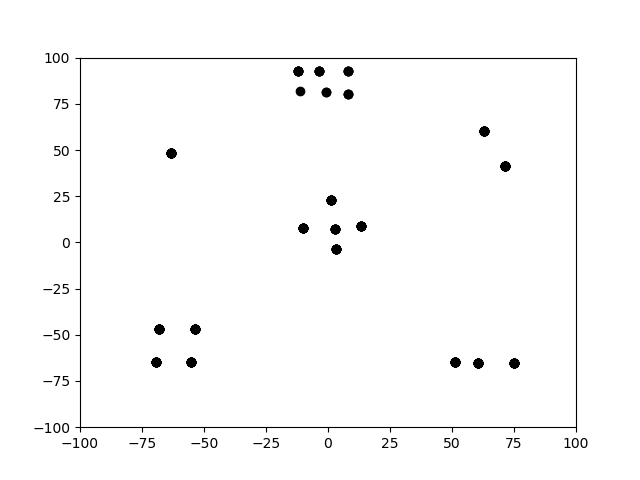

In [49]:
draw_save_points("maps/map")

<IPython.core.display.Javascript object>


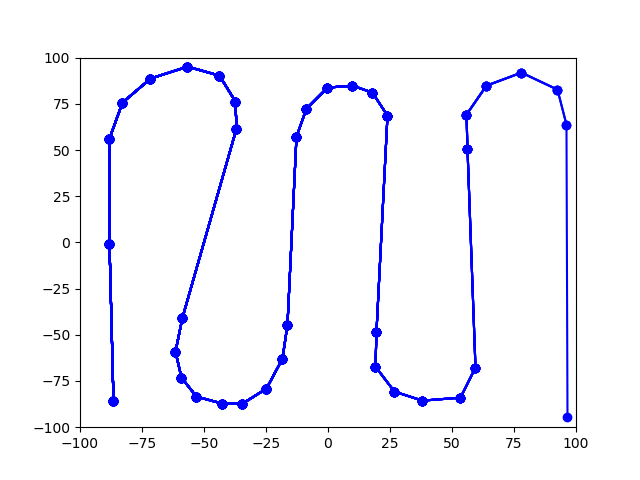

In [47]:
draw_save_points("paths/path", line=True)

In [5]:
class Feature:
    def __init__(self, x, y, s):
        #
        # TODO: write some code here for Feature class initialization
        #
        self.x = x
        self.y = y
        self.s = s

In [6]:
class Map:
    def __init__(self, points):
        self.features = []
        for idx, p in enumerate(points):
            self.features.append(Feature(p[0], p[1], idx))
            

In [7]:
class FeatureSensor:
    R = 5
    def __init__(self, R, Map):
        self.R = R
        self.Map = Map
        
    def getMeasurements(self, robot_pose):
        #
        # TODO: returns list of measurements with reference to current robot pose and sensor range
        #
        measurements = []
        for f in self.Map.features:
            dist = np.sqrt((f.x - robot_pose[0])**2 + (f.y - robot_pose[1])**2)
            if dist >= self.R:
                continue
            angle = np.arctan((f.y - robot_pose[1]) / (f.x - robot_pose[0])) - robot_pose[2]
            measurements.append((dist, angle, f))
            
        return measurements

$x_{t+1} = g(u, x_t) + \delta_t$, where $\delta_t$ - is a noise inducted from $(u,v)$ control space.

G - Jacobian of function g:

$$G = \dfrac{dg(u,x)}{dx}$$

$z = (r,\phi)$ - where $r$ - is distance to feature, $\phi$ - the bearing to feature.

$z = \left(\sqrt{(x - x_i)^2 + (y - y_i)^2}, arctan\left(\dfrac{y - y_i}{x - x_i}\right) - \theta\right) = h(x)$

H - Jacobian of function h:

$$H = \dfrac{dh(x)}{dx}$$


In [184]:
class BycicleSym:
    x, y, theta, omega, v, dt = symbols('x y theta omega v dt')
    eq1 = x + (v / omega) * (-sin(theta)) + (v / omega) * (sin(theta + omega * dt)) 
    eq2 = y + (v / omega) * cos(theta) - (v / omega) * (cos(theta + omega * dt)) 
    eq3 = omega * dt 
    state = Matrix([eq1, eq2, eq3])

class EKF_Localizer:
    def __init__(self, start_mu):
        self.Mu_list = [start_mu]
        self.Sigma_list = [np.array([[1, 0, 0], [0,1,0], [0,0,1]])]
        self.alpha = [0.1, 0.1, 0.1, 0.1]
        
    def predict(self, control):
        #
        # TODO: do prediction step
        #
        g = BycicleSym()
        mu = self.Mu_list[-1]
#         print("mu: {}\ncontrol: {}\n".format(mu, control))
        if np.abs(control[0]) < 0.001:
            state = [0, 0, 0]
            state[0] = mu[0] + control[1] * control[2] * np.cos(mu[2])
            state[1] = mu[1] + control[1] * control[2] * np.sin(mu[2])
            state = np.array([state[0], state[1], state[2]])
            control[0] = 0.01
        else:
            state = g.state.subs([(g.x, mu[0]), (g.y, mu[1]), (g.theta, mu[2]), (g.omega, control[0]), (g.v, control[1]), (g.dt, control[2])])
#         print("state: {}".format(state))
        self.mu = np.array([[state[0]], [state[1]], [state[2]]]).astype(np.float64)
        sigma = self.Sigma_list[-1]
        G = self.getG(control)
        V = self.getV(control)
        M = np.array([[self.alpha[0]*(control[1] ** 2) + self.alpha[1]*(control[0] ** 2),0],
                      [0, self.alpha[2]*(control[1] ** 2) + self.alpha[3]*(control[0] ** 2)]])
        self.sigma = G @ sigma @ G.T + V @ M @ V.T
#         print("G: {}".format(G))
#         print("V: {}".format(V))
#         print("M: {}".format(M))
#         print("sigma: {}".format(self.sigma))
        
        
    def update(self, measurements):
        #
        # TODO: do update step
        #
        # Шум сенсоров?
        Q = np.array([[1, 0] , [0, 1]])
        for z in measurements:
            H, r, phi = self.getH(z[2])
            S = H @ self.sigma @ H.T + Q
            K = self.sigma @ H.T @ np.linalg.inv(S)
#             print("S: {}".format(S))
#             print("inv: {}".format(np.linalg.inv(S)))
#             print("z - z^: {}".format(np.array([z[0] - r, z[1] - phi])))
#             print("K: {}".format(K))
            self.mu = self.mu + K @ (np.array([z[0] - r, z[1] - phi]))
            self.sigma = (np.eye(3) - K @ H) @ self.sigma
        self.Mu_list.append(self.mu)
        self.Sigma_list.append(self.sigma)
#         print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
        
        
    def getG(self, control):
        #
        # TODO: computer Jacobian of nonlinear function g(u,x) with respect to state x
        #
        mu = self.Mu_list[-1]
        g = BycicleSym()
        eq1dx = diff(g.eq1, g.x)
        eq1dy = diff(g.eq1, g.y) 
        eq1dth = diff(g.eq1, g.theta) 
        eq2dx = diff(g.eq2, g.x)
        eq2dy = diff(g.eq2, g.y) 
        eq2dth = diff(g.eq2, g.theta) 
        eq3dx = diff(g.eq3, g.x)
        eq3dy = diff(g.eq3, g.y) 
        eq3dth = diff(g.eq3, g.theta) 
        G = Matrix([[eq1dx, eq1dy, eq1dth], [eq2dx, eq2dy, eq2dth], [eq3dx, eq3dy, eq3dth]])
#         pprint(G)
        G = G.subs([(g.x, mu[0]), (g.y, mu[1]), (g.theta, mu[2]), (g.omega, control[0]), (g.v, control[1]), (g.dt, control[2])])
        G = np.array(G).astype(np.float64)
        return G
        
    def getV(self, control):
        #
        # TODO: compute Jacobian of nonlinear function g(u,x) with respect to control u
        #
        mu = self.Mu_list[-1]
        g = BycicleSym()
        eq1dv = diff(g.eq1, g.v)
        eq1domega = diff(g.eq1, g.omega) 
        eq2dv = diff(g.eq2, g.v)
        eq2domega = diff(g.eq2, g.omega) 
        eq3dv = diff(g.eq3, g.v)
        eq3domega = diff(g.eq3, g.omega) 
        V = Matrix([[eq1dv, eq1domega], [eq2dv, eq2domega], [eq3dv, eq3domega]])
        V = V.subs([(g.x, mu[0]), (g.y, mu[1]), (g.theta, mu[2]), (g.omega, control[0]), (g.v, control[1]), (g.dt, control[2])])
        V = np.array(V).astype(np.float64)
        return V
    
    def getH(self, obs):
        mu = self.Mu_list[-1]
        m_x, m_y, mu_x, mu_y, theta = symbols('m_x, m_y, mu_x, mu_y, theta')
        r = sqrt((m_x - mu_x)**2 + (m_y - mu_y)**2)
        phi = atan2(m_y - mu_y, m_x - mu_x ) - theta
#         pprint(r)
#         print('\n')
#         pprint(phi)
#         print('\n')
        
        rdx = diff(r, mu_x)
        rdy = diff(r, mu_y)
        rdth = diff(r, theta)
        phidx = diff(phi, mu_x)
        phidy = diff(phi, mu_y)
        phidth = diff(phi, theta)
        H = Matrix([[rdx, rdy, rdth], [phidx, phidy, phidth]])
#         pprint(H)
#         print('\n')
#         print([obs.x, obs.y], mu)
#         print('\n')
        
        H = H.subs([(m_x, obs.x), (m_y, obs.y), (mu_x, mu[0]), (mu_y, mu[1]), (theta, mu[2])])
#         pprint(H)
        H = np.array(H).astype(np.float64)
        r = r.subs([(m_x, obs.x), (m_y, obs.y), (mu_x, mu[0]), (mu_y, mu[1]), (theta, mu[2])])
        r =  np.array(r).astype(np.float64)
        phi = phi.subs([(m_x, obs.x), (m_y, obs.y), (mu_x, mu[0]), (mu_y, mu[1]), (theta, mu[2])])
        phi = np.array(phi).astype(np.float64)
#         print("H: {}".format(H))
#         print("r: {}".format(r))
#         print("phi: {}".format(phi))
        
        return H, r, phi
        
    

In [345]:
class EKF_Experiment:
    def __init__(self, bycicleModel, pidController, trajectory, sensors):
        self.model = bycicleModel
        self.pid = pidController
        self.trajectory = trajectory
        self.sensors = sensors
        self.localizer = EKF_Localizer(self.model.getStateVector())
        self.pos = [self.model.getPosition()]
        
    
    def run(self, speed, dt, max_iterations):
        for i in tqdm_notebook(range(max_iterations)):
            CTE = self.trajectory.getDistanceFromPoint(self.model.getPosition())
            angle_speed = self.pid.update(CTE)
            
            self.model.Move2(angle_speed, speed, dt)
            self.pos.append(self.model.getPosition())
            
            self.localizer.predict([angle_speed, speed, dt])
            self.localizer.update(self.sensors.getMeasurements( self.model.getStateVector() ))
#             if i % 50 == 0:
#                 print(i, self.model.getPosition())
       
    def draw_path(self):
        fig, ax = plt.subplots()
        ax.plot([p.x for p in self.pos], [p.y for p in self.pos],
                         color='red', marker='.', scalex=False, scaley=False, label='Robot')
        ax.set_ylim([-100,100])
        ax.set_xlim([-100,100])
        plt.show()
        fig.canvas.draw()
        
    def draw_all(self, lim = None):
        if lim == None:
            lim = len(self.localizer.Mu_list)
        M = np.array(self.localizer.Mu_list)
        E = np.array(self.localizer.Sigma_list)
        x = M[:,0]
        y = M[:,1]
        fig, ax = plt.subplots(figsize=(10,10))
        for i in range(0,lim,1):
            lambda_, v = np.linalg.eig(np.array(E[i]))
            lambda_ = np.sqrt(lambda_)
            ell = Ellipse(xy=(x[i], y[i]),
                          width=lambda_[0], height=lambda_[1],
                          angle=np.rad2deg(np.arccos(v[0, 0])), linewidth=1, fill=False)
            if i%1 == 0:
                ax.add_artist(ell)
        plt.plot(M[:lim,0], M[:lim,1], label='EKF_Localizer')
        plt.xlabel('Xt')
        plt.ylabel('Yt')
        plt.grid(True)
        
        ax.plot([p.x for p in self.pos], [p.y for p in self.pos],
                         color='red', marker='.', scalex=False, scaley=False, label='Robot')
        
        ax.plot([p.x for p in self.trajectory.coords], [p.y for p in self.trajectory.coords],
                         color='grey', linestyle='--', scalex=False, scaley=False, label='path')
        
        for f in self.sensors.Map.features:
            ax.plot(f.x, f.y, 'o', color="green")
            ax.annotate(f.s, (f.x, f.y))
        
    #     plt.axis('equal')
        plt.legend()
        plt.show()


In [346]:
def set_experiment(R = 20, dt = 0.1, pid = (100, 10, 30), map_id=0, path_id=2):
    loaded = np.loadtxt("paths/path_{}.txt".format(path_id))
    coords = [geom.Point(p) for p in loaded]
    m = Map(np.loadtxt("maps/map_{}.txt".format(map_id)))
    # найдём начальный угол
    a = (1,0)
    b = (coords[1].x - coords[0].x, coords[1].y - coords[0].y)
    product = b[0]
    theta = np.arccos(product / np.sqrt(b[0]**2 + b[1]**2)) 
#     print(theta * 57)
    
    model = BicycleModel(coords[0].x, coords[0].y, theta)
    return EKF_Experiment(model, PID(pid[0], pid[1], pid[2], dt),  Trajectory(coords), FeatureSensor(R, m))


<IPython.core.display.Javascript object>


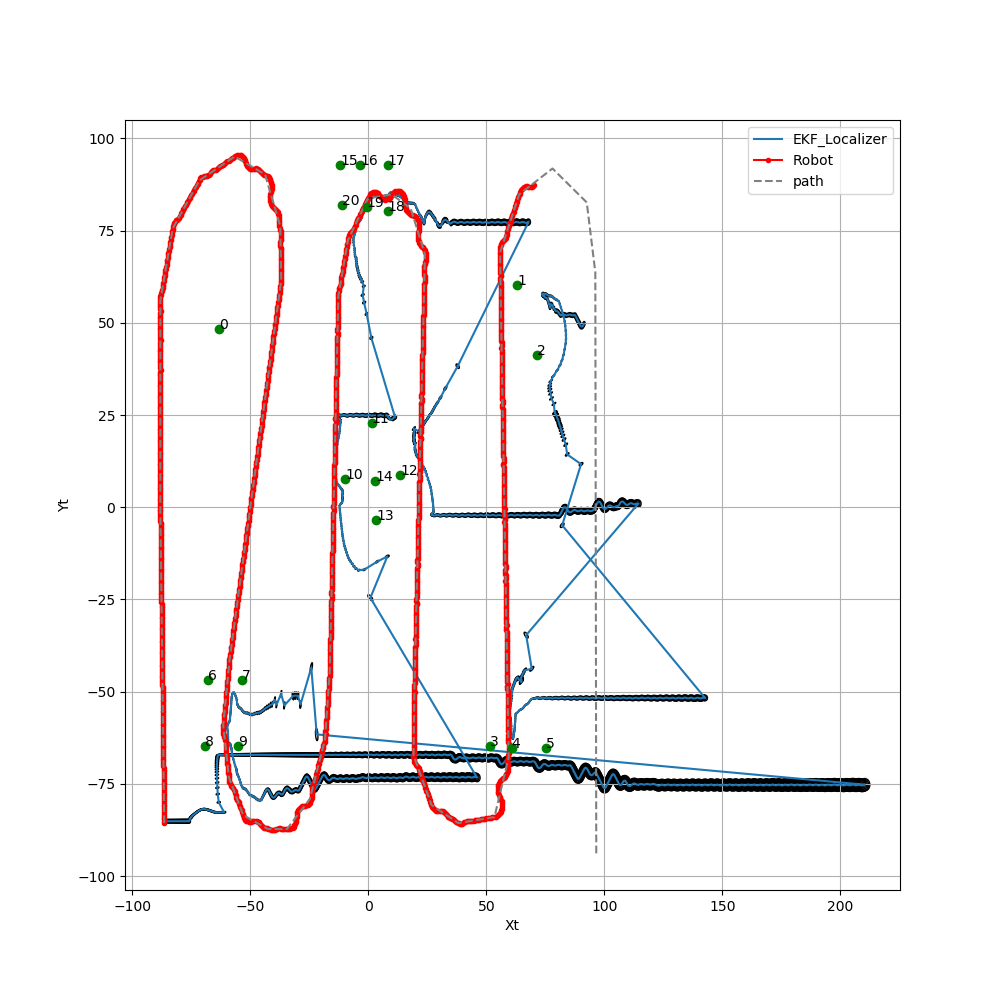

In [360]:
dt = 0.1
speed = 5
iterations = 2001
pid = (15, 0, 2)
map_id = 2
path_id = 2
R = 20

Exp1 = set_experiment(R = R, dt = dt, pid = pid, map_id=map_id, path_id=path_id)
Exp1.run(speed, dt, iterations)
Exp1.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


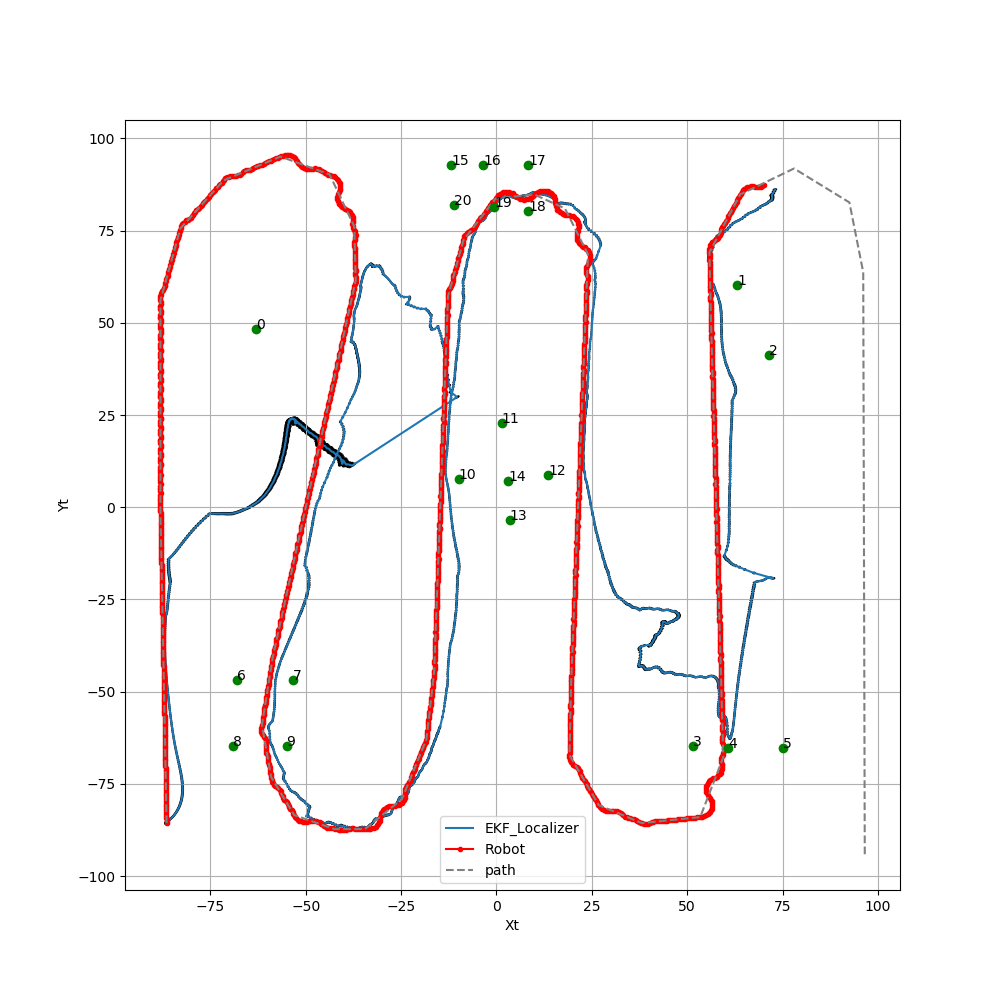

In [355]:
Exp2 = set_experiment(R = 50, dt = dt, pid = pid, map_id=map_id, path_id=path_id)
Exp2.run(speed, dt, iterations)
Exp2.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


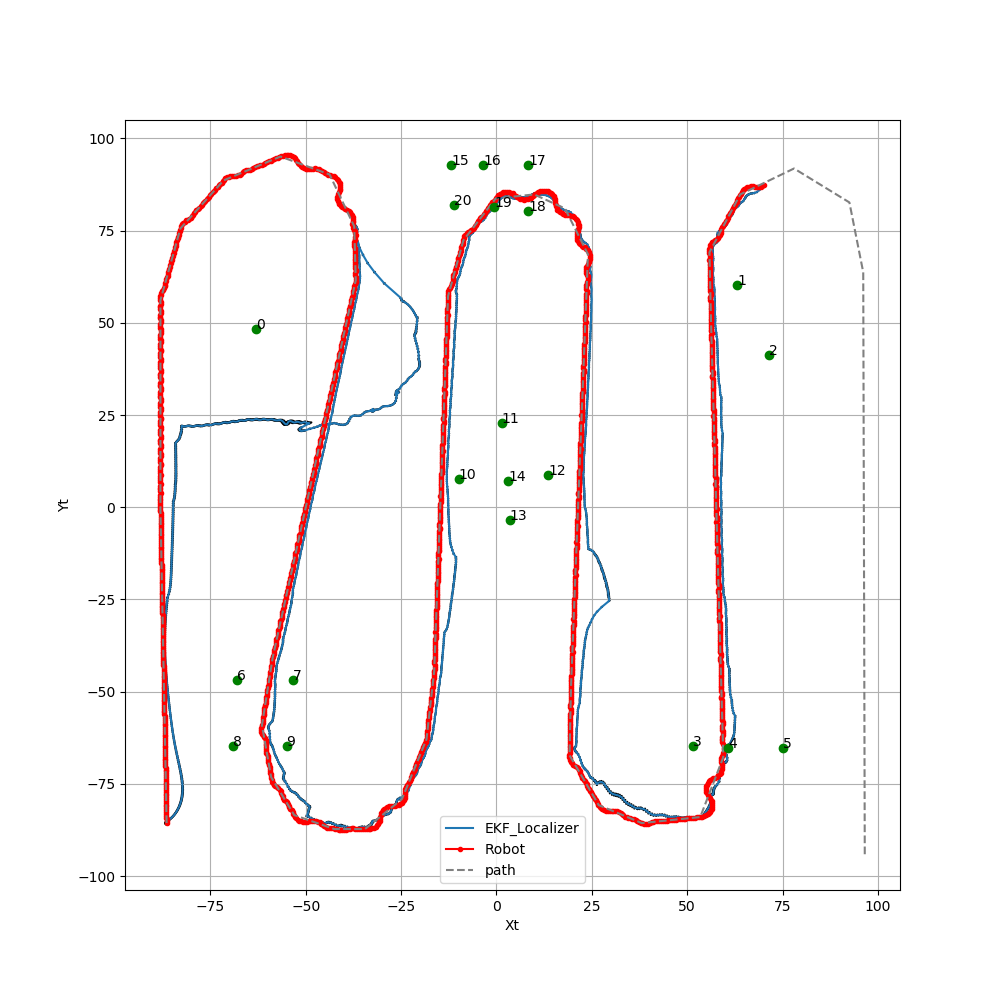

In [364]:
Exp22 = set_experiment(R = 75, dt = dt, pid = pid, map_id=map_id, path_id=path_id)
Exp22.run(speed, dt, iterations)
Exp22.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


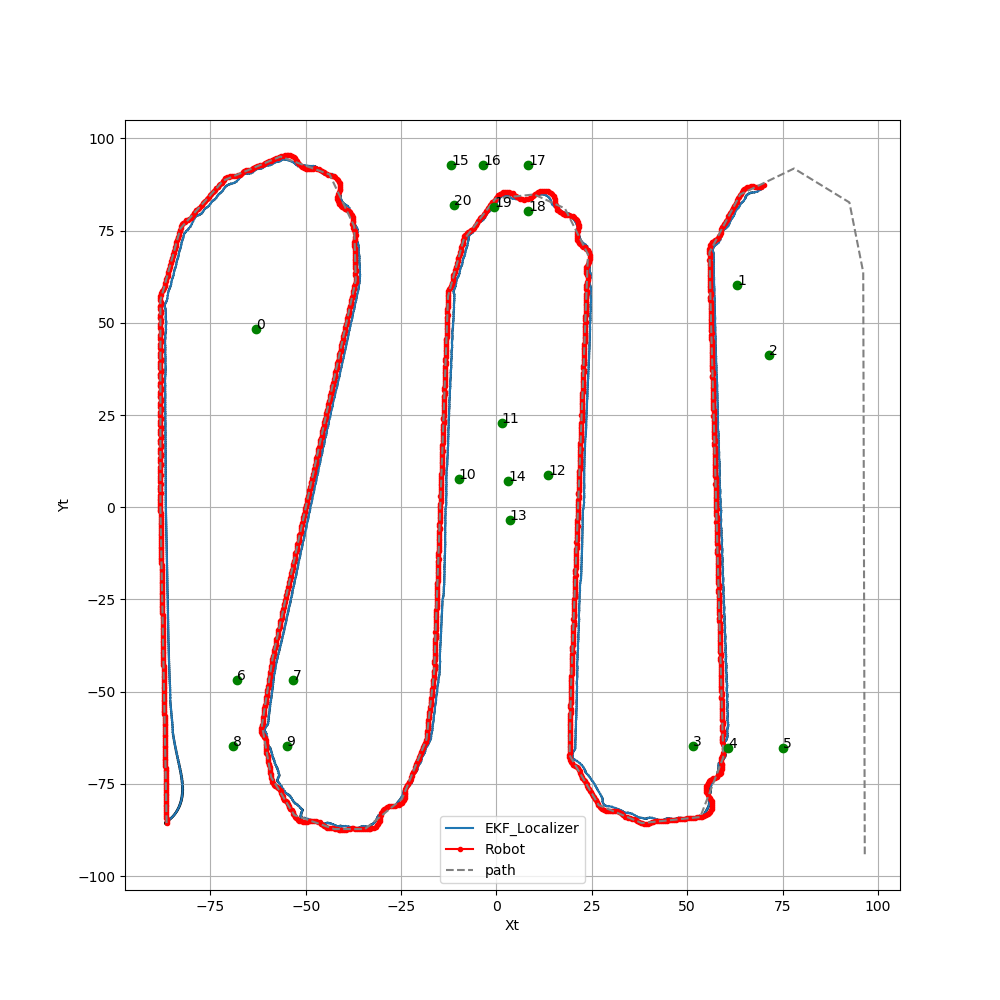

In [361]:
Exp21 = set_experiment(R = 100, dt = dt, pid = pid, map_id=map_id, path_id=path_id)
Exp21.run(speed, dt, iterations)
Exp21.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


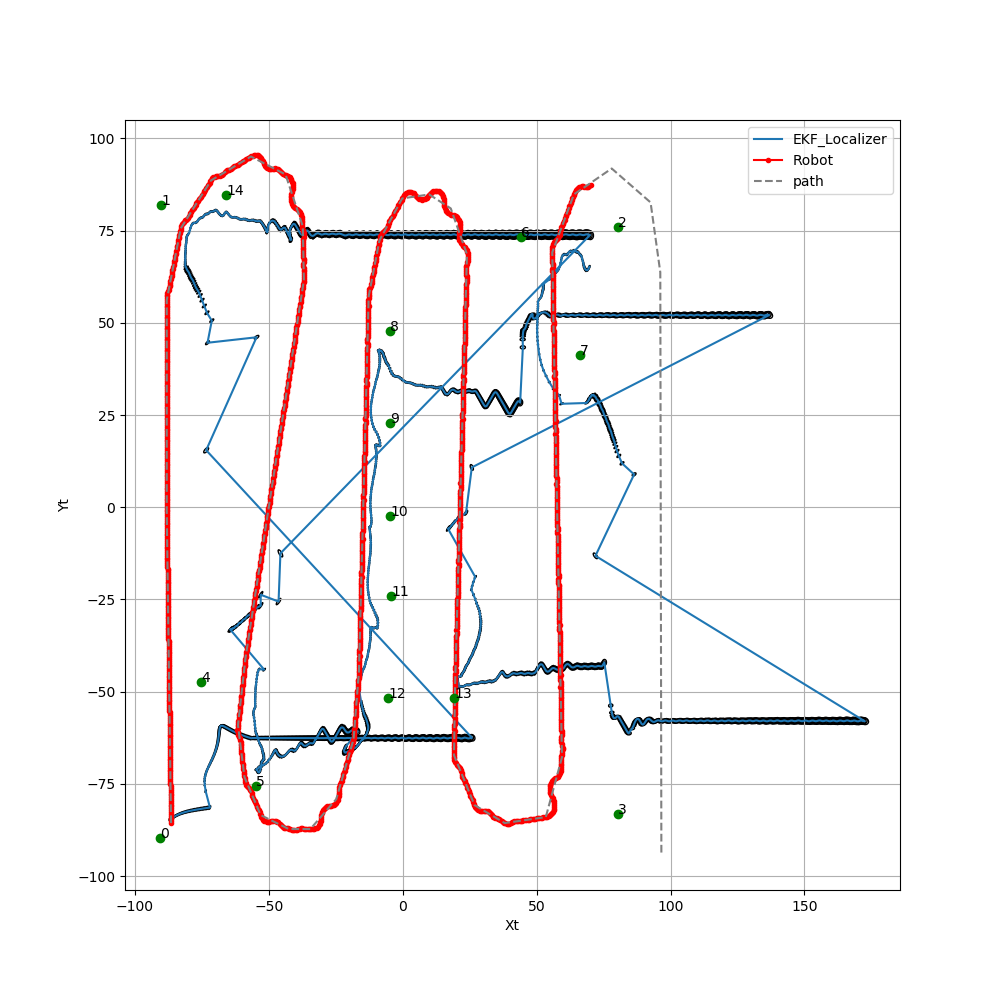

In [356]:
Exp3 = set_experiment(R = 25, dt = dt, pid = pid, map_id=0, path_id=path_id)
Exp3.run(speed, dt, iterations)
Exp3.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


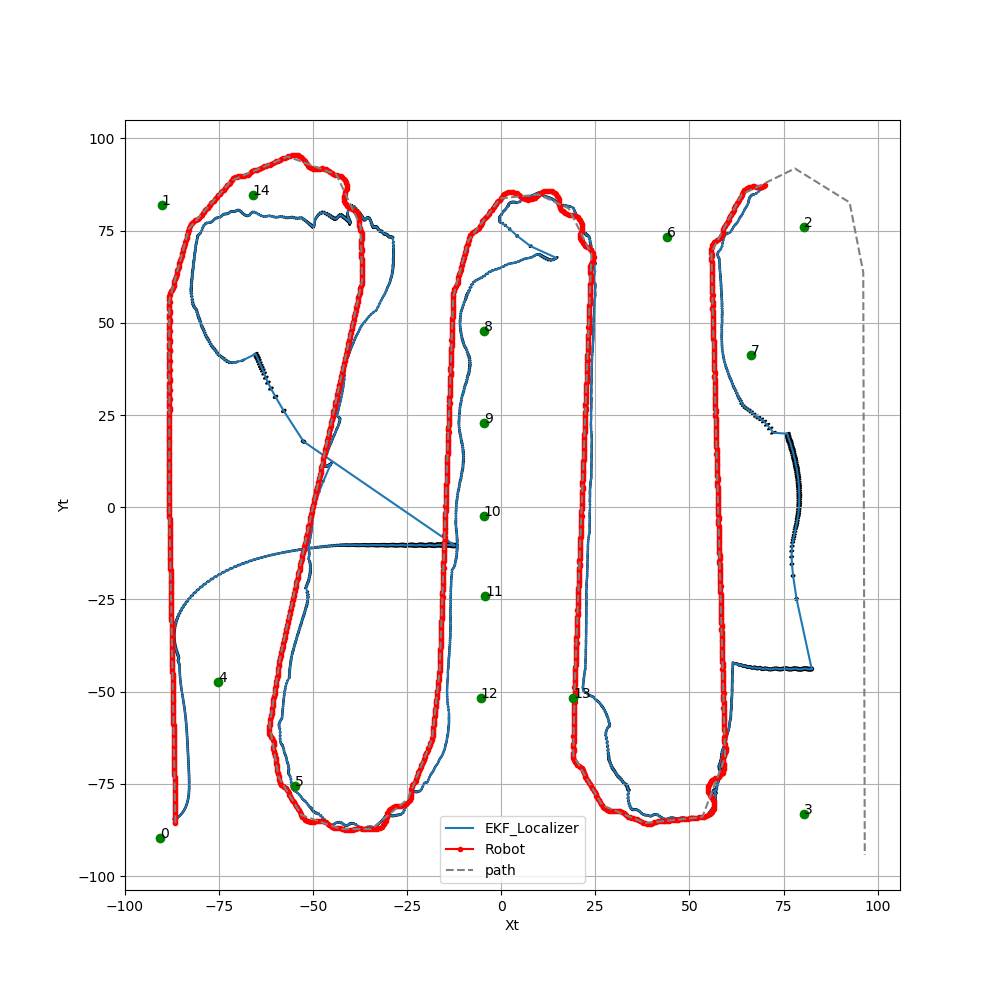

In [357]:
Exp4 = set_experiment(R = 50, dt = dt, pid = pid, map_id=0, path_id=path_id)
Exp4.run(speed, dt, iterations)
Exp4.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


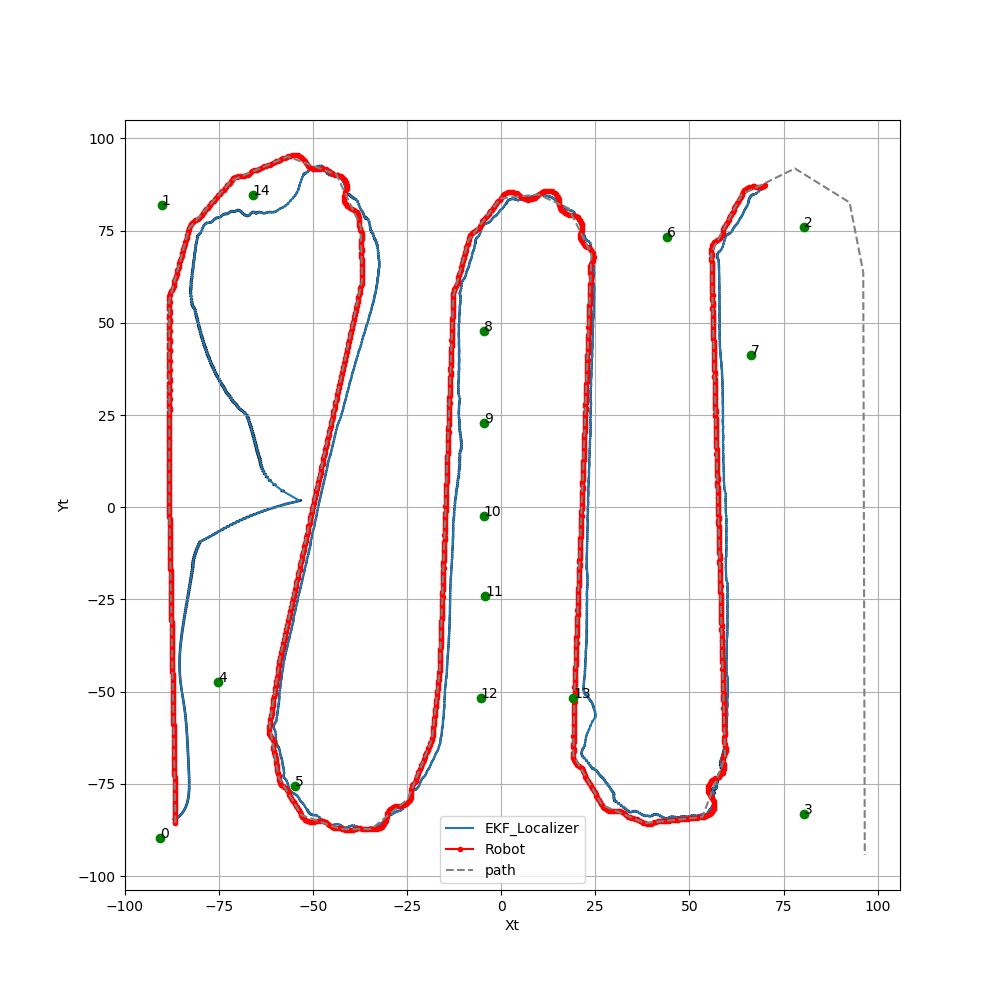

In [366]:
Exp42 = set_experiment(R = 75, dt = dt, pid = pid, map_id=0, path_id=path_id)
Exp42.run(speed, dt, iterations)
Exp42.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


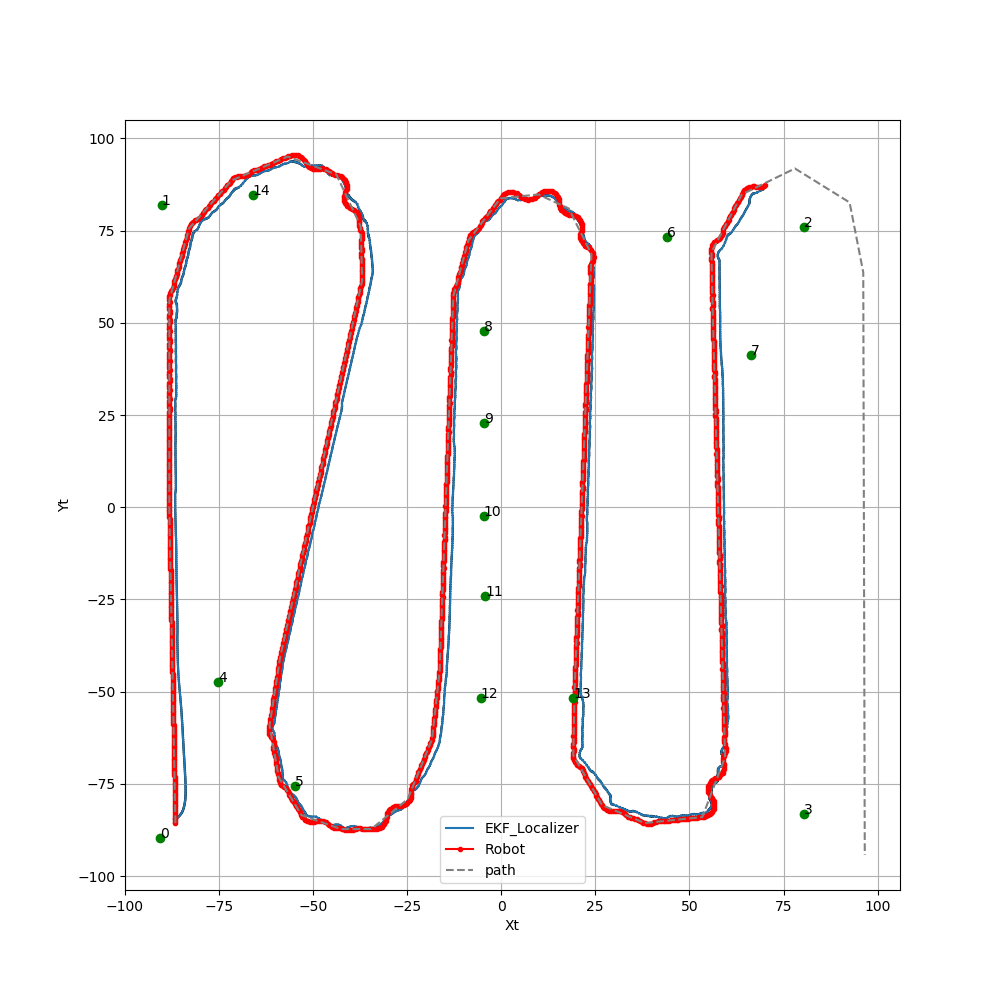

In [362]:
Exp41 = set_experiment(R = 100, dt = dt, pid = pid, map_id=0, path_id=path_id)
Exp41.run(speed, dt, iterations)
Exp41.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


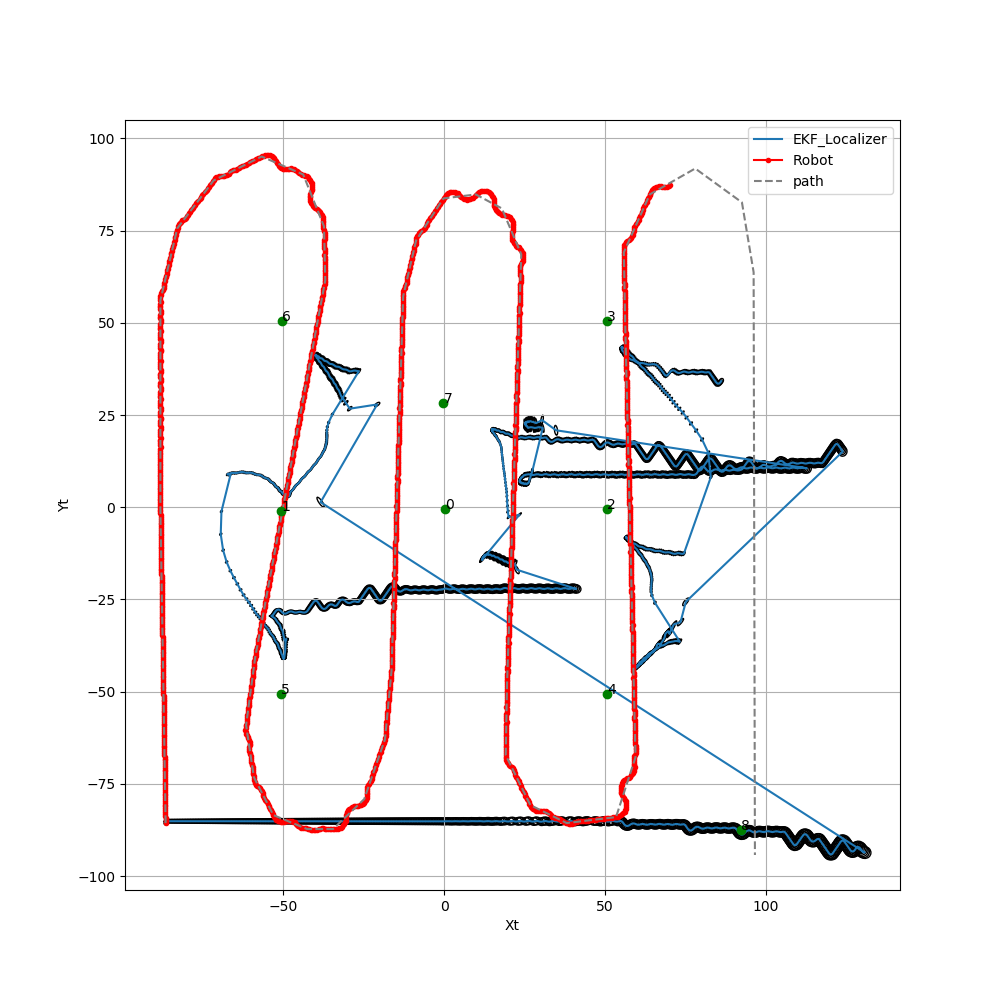

In [358]:
Exp5 = set_experiment(R = 25, dt = dt, pid = pid, map_id=1, path_id=path_id)
Exp5.run(speed, dt, iterations)
Exp5.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


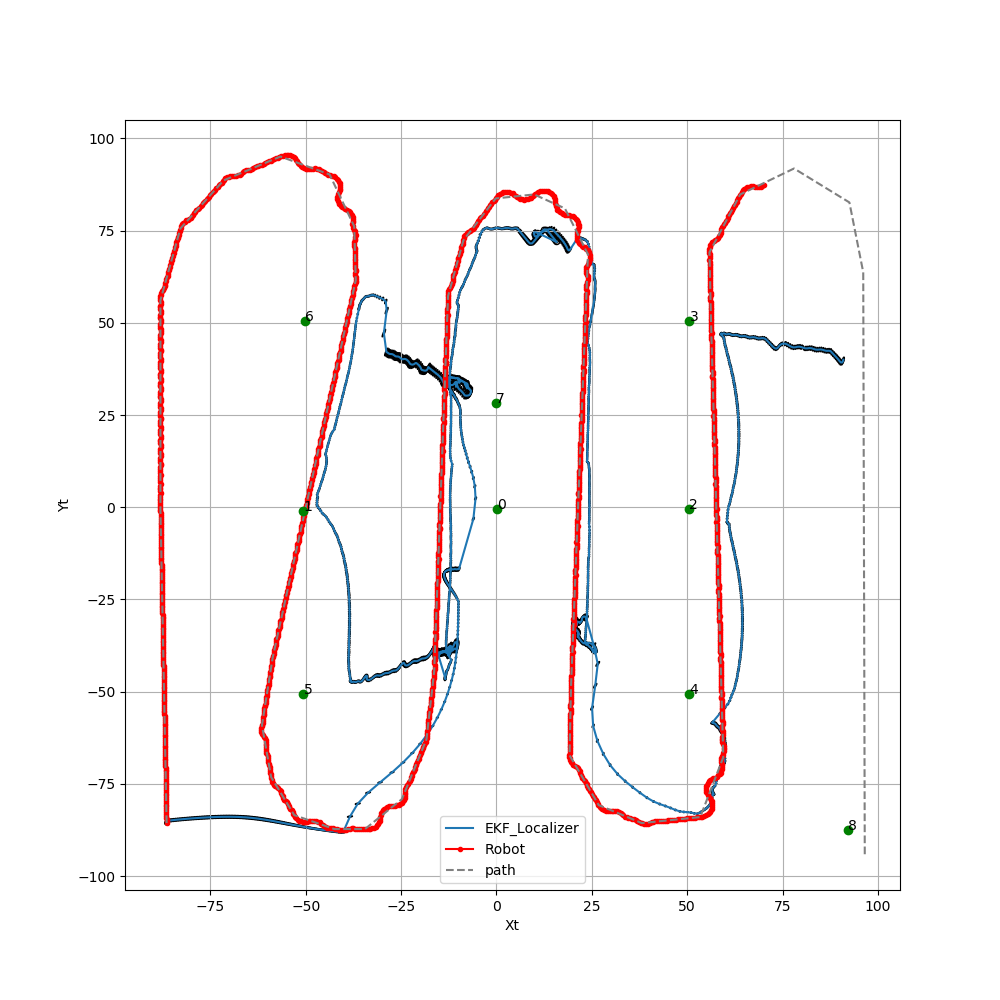

In [359]:
Exp6 = set_experiment(R = 50, dt = dt, pid = pid, map_id=1, path_id=path_id)
Exp6.run(speed, dt, iterations)
Exp6.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


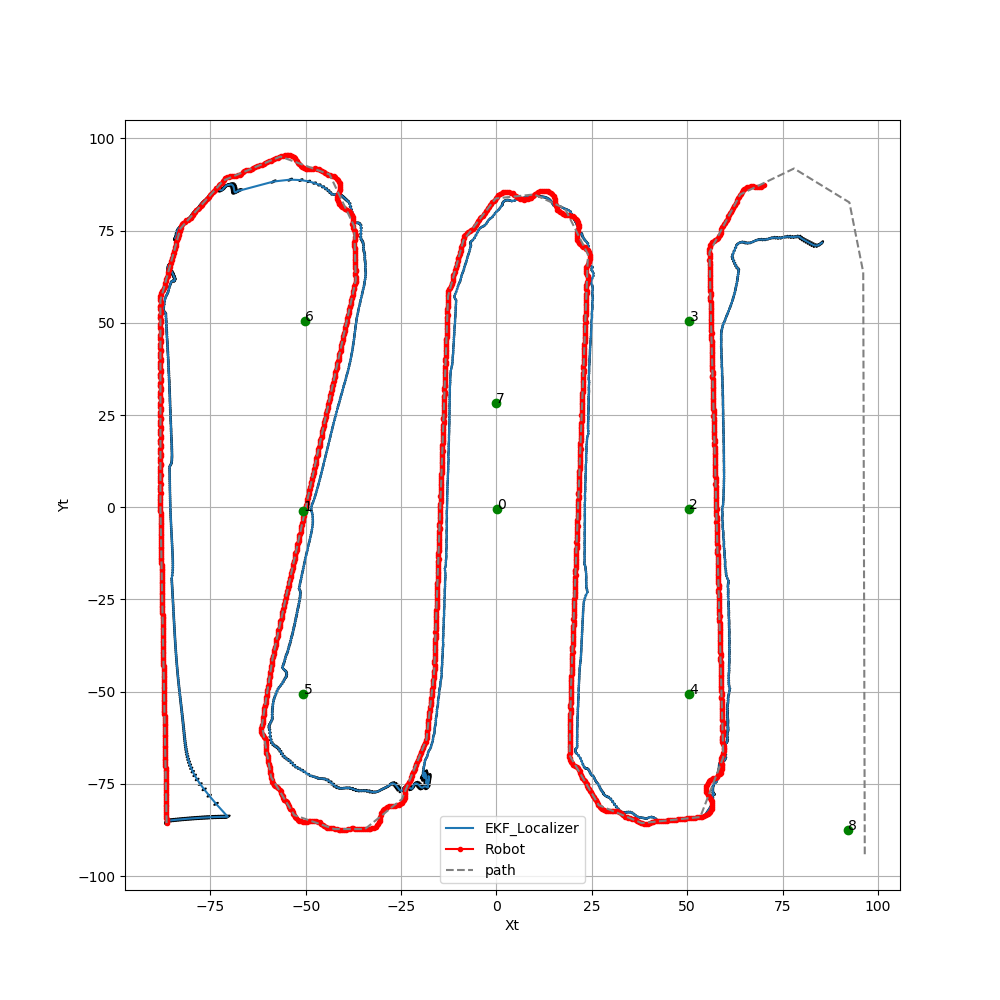

In [365]:
Exp62 = set_experiment(R = 75, dt = dt, pid = pid, map_id=1, path_id=path_id)
Exp62.run(speed, dt, iterations)
Exp62.draw_all(lim = 2000)

HBox(children=(IntProgress(value=0, max=2001), HTML(value='')))

<IPython.core.display.Javascript object>


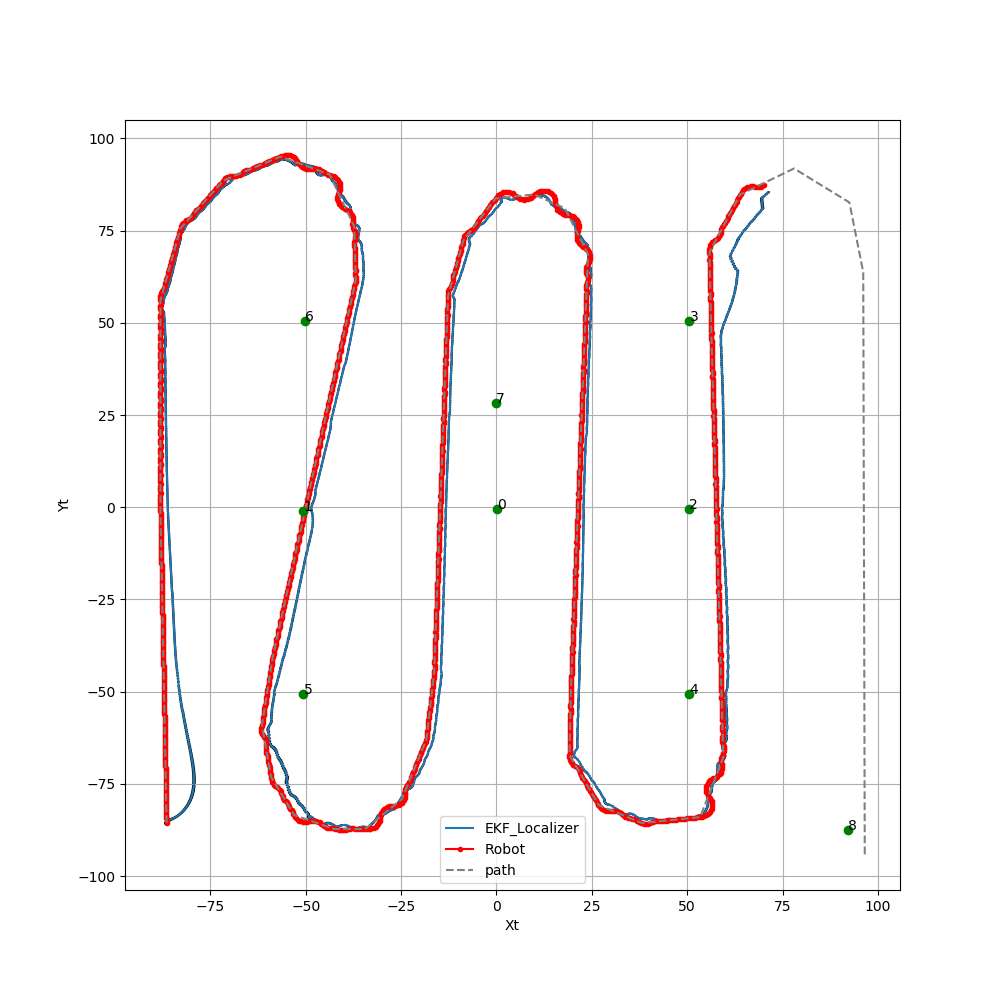

In [363]:
Exp61 = set_experiment(R = 100, dt = dt, pid = pid, map_id=1, path_id=path_id)
Exp61.run(speed, dt, iterations)
Exp61.draw_all(lim = 2000)

#### Проверим результат локализации, когда робот стоит на месте

HBox(children=(IntProgress(value=0, max=201), HTML(value='')))

<IPython.core.display.Javascript object>


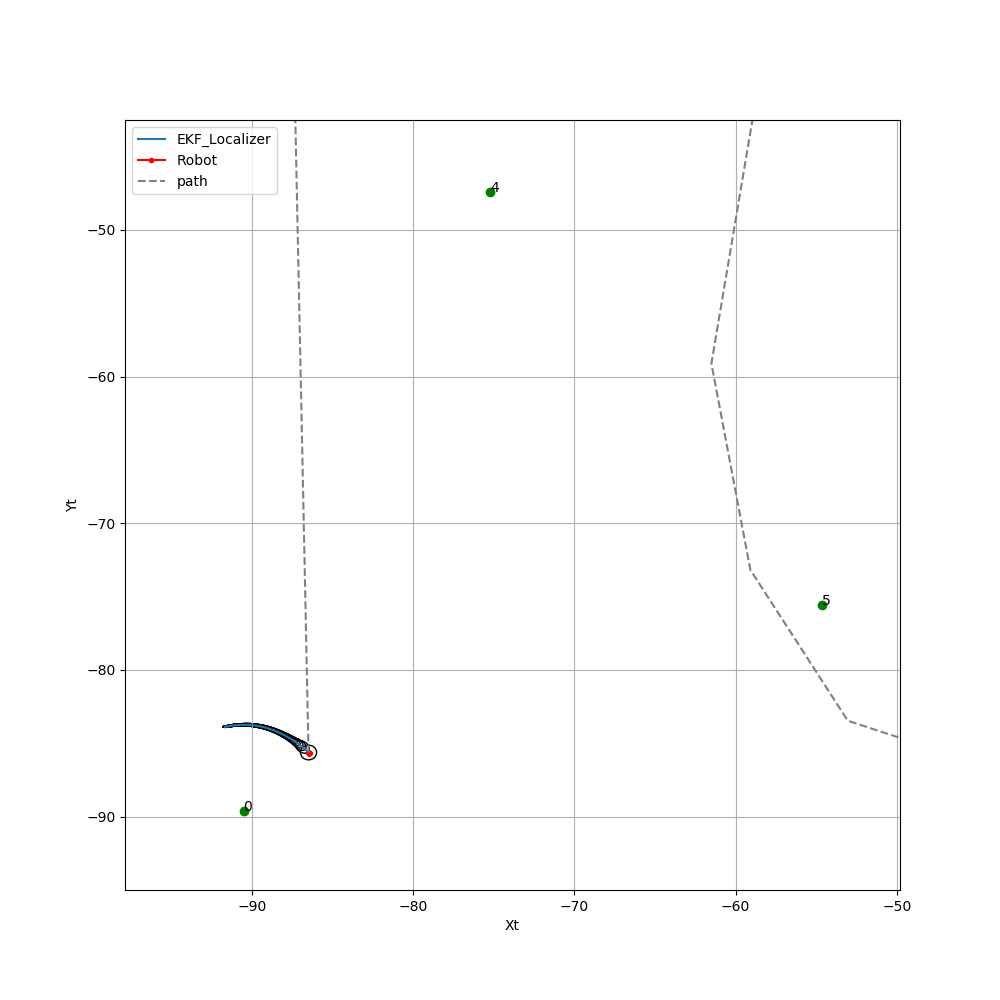

In [372]:
ExpStop = set_experiment(R = 25, dt = dt, pid = pid, map_id=0, path_id=path_id)
ExpStop.run(0, dt, 201)
ExpStop.draw_all(lim = 200)

HBox(children=(IntProgress(value=0, max=201), HTML(value='')))

<IPython.core.display.Javascript object>


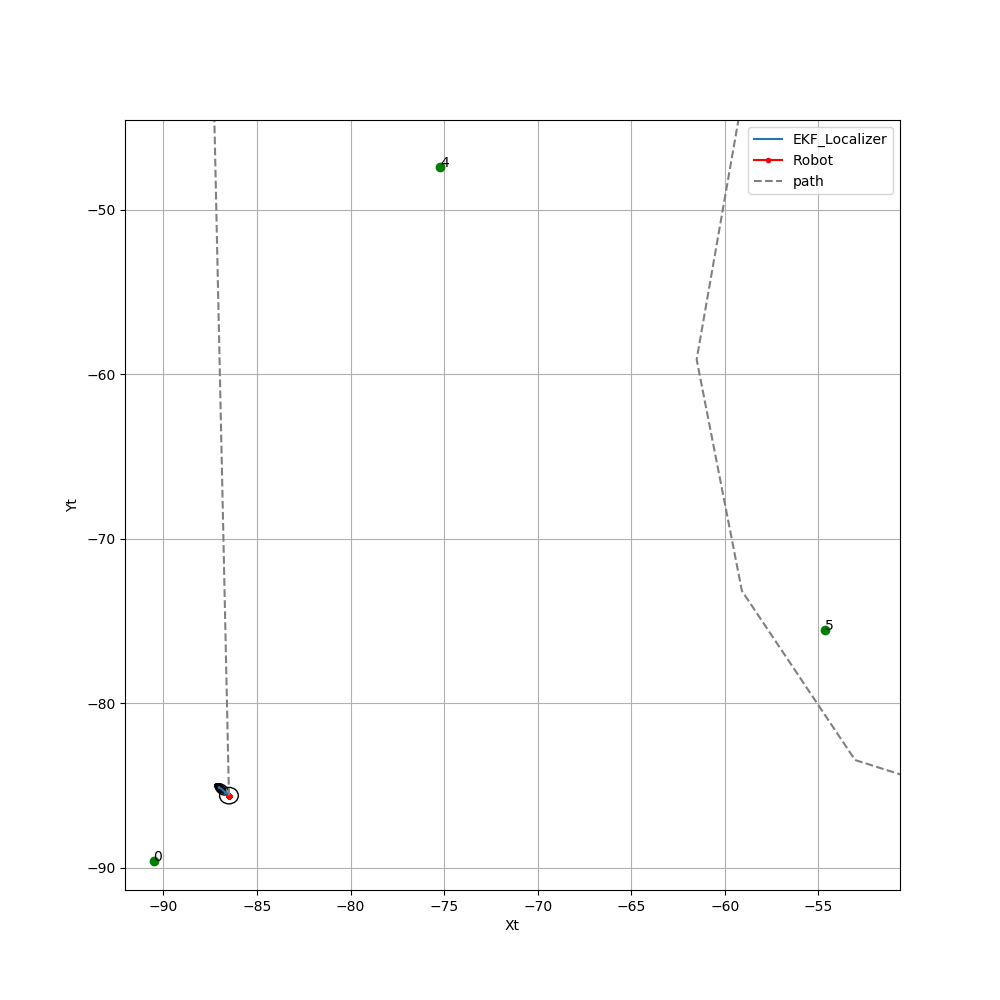

In [376]:
ExpStop = set_experiment(R = 41, dt = dt, pid = pid, map_id=0, path_id=path_id)
ExpStop.run(0, dt, 201)
ExpStop.draw_all(lim = 200)

HBox(children=(IntProgress(value=0, max=201), HTML(value='')))

<IPython.core.display.Javascript object>


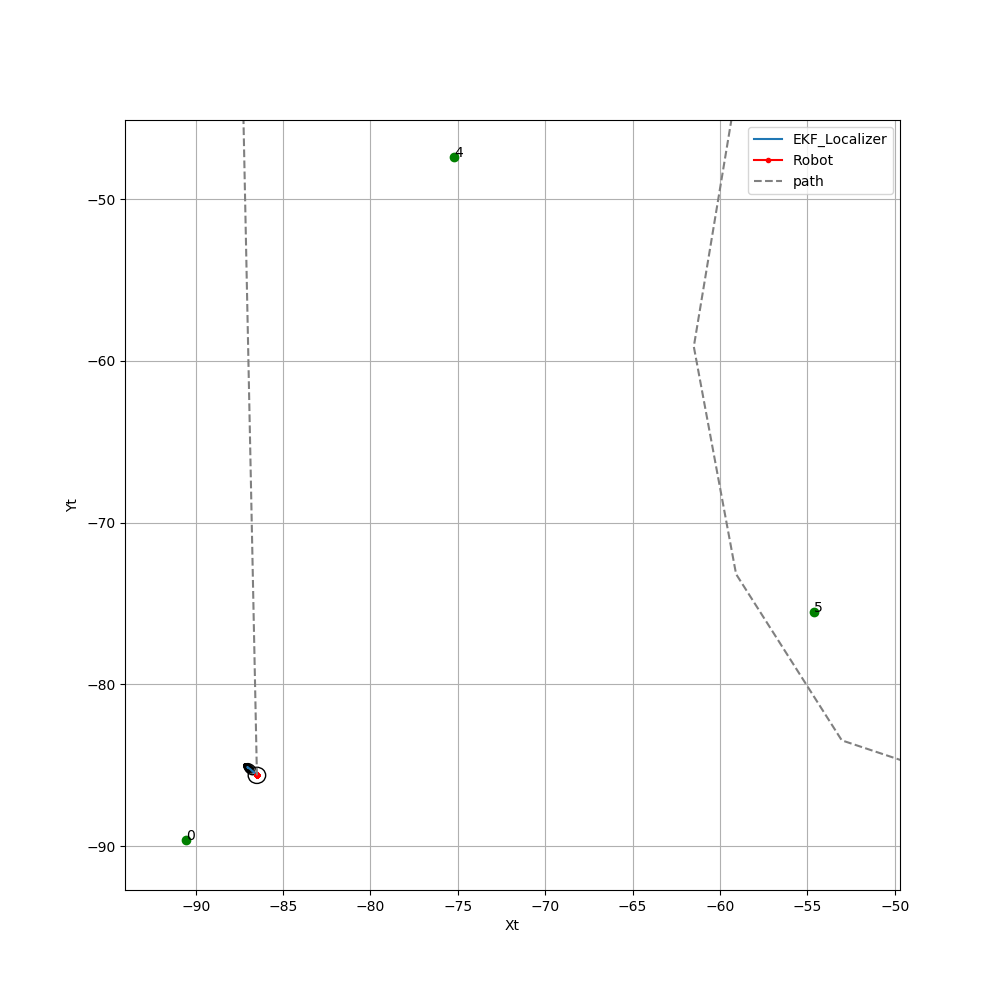

In [374]:
ExpStop = set_experiment(R = 75, dt = dt, pid = pid, map_id=0, path_id=path_id)
ExpStop.run(0, dt, 201)
ExpStop.draw_all(lim = 200)

Хорошо заметно, что если видно только 1 маяк, локализация начинает куда-то "уплывать" из-за шумов, при большем количестве видимых маяков результат получается стабильнее

## Project report:

Put your report here. Feel free to use pictures, graphs, animations.



Если робот не видит маяков, то локализация может быть с очень большими погрешностями, иногда бывают странные повороты, хотя робот при этом едет прямо. Скорее всего, это происходит из-за шумов пространства управления.
Наличие видимых маяков не гарантирует хороший результат, одного видимого маяка обычно не хватает для хорошей локализации, т.к есть много вариантов положения робота относительно маяка. Двух в общем-то тоже не хватает, хотя там всё гораздо лучше.

